# NSF

In [2]:
# Libraries

from os.path import join
from os import listdir
from bs4 import BeautifulSoup
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## 1. Parsing XML

In [ ]:
# Option 1: List of file paths for all years

years = list(range(2002,2021))
filelist = []

for year in years:
    folder_path = join('data/nsf/'+str(year))
    filelist.extend([join(folder_path,f) for f in listdir(folder_path)])

In [ ]:
# Option 2: Filelist year by year

year = 2020
folder_path = join('data/nsf/'+str(year))
filelist = []
filelist.extend([join(folder_path,f) for f in listdir(folder_path)])

In [ ]:
# Option 3: File by file (testing purposes)

xmlfile = open('data/nsf/2002/0200014.xml','r')
xml_soup = BeautifulSoup(xmlfile,'xml')
for element in xml_soup.find_all():
    for column in list(xml_df):
        if(element.name==column):
            dict_aux[column] = element.string

xml_df = xml_df.append(dict_aux,ignore_index=True)

In [ ]:
# XML Schema

xsd_file = open('data/nsf/Award.xsd','r')
xsd_soup = BeautifulSoup(xsd_file)

tags = []
for element in xsd_soup.find_all('xsd:element'):
    tags.append(element['name'])

In [ ]:
# Build dataframe (Options 1 & 2)

xml_df = pd.DataFrame(columns=tags)
dict_aux = {}

for file in filelist:
    xmlfile = open(file,'r')
    xml_soup = BeautifulSoup(xmlfile,'xml')
    for element in xml_soup.find_all(): 
        for column in list(xml_df):
            if(element.name==column):
                dict_aux[column] = element.string
    xml_df = xml_df.append(dict_aux,ignore_index=True)
    dict_aux = {}

In [ ]:
# Write dataframe to csv file (Option 2: year by year)

xml_df.to_csv('data/nsf/nsf_2020.csv')

In [ ]:
# Load csvs into joint dataframe (Option 2: year by year)

columns_dates = ['AwardEffectiveDate','AwardExpirationDate']
nsf_list = []

for file in listdir("data/nsf"):
    if file.endswith(".csv"):
        df = pd.read_csv(join('data/nsf',file),parse_dates=columns_dates)
        nsf_list.append(df)

nsf = pd.concat(nsf_list)
nsf.to_csv('data/nsf/nsf_raw.csv')

## 2. Preprocessing

In [3]:
# Load csv (Option 1: all in one)

columns_dates = ['AwardEffectiveDate','AwardExpirationDate','MinAmdLetterDate','MaxAmdLetterDate','StartDate']
nsf = pd.read_csv('data/nsf/nsf_raw.csv',parse_dates=columns_dates)

In [4]:
print('Shape of the original NSF dataset: ')
nsf.shape

Shape of the original NSF dataset: 


(688506, 50)

In [5]:
# Duration in days
# nsf['durationAward'] = (nsf['AwardExpirationDate'] - nsf['AwardEffectiveDate']).dt.days

# Extract years
nsf['awardEffectiveYear'] = pd.DatetimeIndex(nsf['AwardEffectiveDate']).year
nsf['awardExpirationYear'] = pd.DatetimeIndex(nsf['AwardExpirationDate']).year
nsf['startYear'] = pd.DatetimeIndex(nsf['StartDate']).year
nsf = nsf[(nsf['startYear']>2001) & (nsf['startYear']<2021)]
nsf = nsf.drop(columns=['AwardExpirationDate','AwardEffectiveDate','StartDate'])
nsf = nsf.fillna({'startYear':0})
nsf = nsf.astype({"startYear":'int'}) 

In [6]:
# Find columns with many null values

cols_to_drop = []

for col in nsf.columns:
    if(nsf[col].isnull().sum() > 12000):
        cols_to_drop.append(col)
        
print('Columns to drop: ',len(cols_to_drop))
cols_to_drop

Columns to drop:  22


['rootTag',
 'Award',
 'AwardInstrument',
 'Organization',
 'Directorate',
 'Division',
 'ProgramOfficer',
 'ARRAAmount',
 'Investigator',
 'EmailAddress',
 'EndDate',
 'Institution',
 'CityName',
 'PhoneNumber',
 'StreetAddress',
 'FoaInformation',
 'ProgramElement',
 'Text',
 'ProgramReference',
 'Text.1',
 'Unnamed: 0.1.1',
 'Unnamed: 0.1.1.1']

In [7]:
# Drop useless columns

cols_to_drop.extend(['Unnamed: 0','Unnamed: 0.1','Code','LongName.1','Code.1','Name.1','Code.2','Code.3'])

nsf = nsf.drop(columns=cols_to_drop)

In [8]:
nsf.dtypes

AwardTitle                     object
AwardAmount                     int64
Value                          object
LongName                       object
SignBlockName                  object
AbstractNarration              object
MinAmdLetterDate       datetime64[ns]
MaxAmdLetterDate       datetime64[ns]
AwardID                       float64
FirstName                      object
LastName                       object
RoleCode                       object
Name                           object
ZipCode                        object
CountryName                    object
StateName                      object
StateCode                      object
awardEffectiveYear              int64
awardExpirationYear             int64
startYear                       int64
dtype: object

In [9]:
nsf = nsf.drop_duplicates()
nsf

,AwardTitle,AwardAmount,Value,LongName,SignBlockName,AbstractNarration,MinAmdLetterDate,MaxAmdLetterDate,AwardID,FirstName,LastName,RoleCode,Name,ZipCode,CountryName,StateName,StateCode,awardEffectiveYear,awardExpirationYear,startYear
0,Collaborative Research: Framework: Software: N...,700000,Standard Grant,Office of Advanced Cyberinfrastructure (OAC),Seung-Jong Park,This award supports the design and implementat...,2018-09-12,2018-09-12,1835704.0,Catherine,Olschanowsky,Principal Investigator,NSF RESEARCH & RELATED ACTIVIT,837251135,United States,Idaho,ID,2018,2022,2018
1,CRI: CI-P: Creating the Largest Speech Emotion...,115390,Standard Grant,Division Of Computer and Network Systems,Tatiana Korelsky,This community infrastructure planning project...,2018-07-25,2020-03-30,1823166.0,Carlos,Busso,Principal Investigator,University of Texas at Dallas,750803021,United States,Texas,TX,2018,2021,2018
2,Collaborative Research: Targeted Observation b...,588488,Continuing Grant,Div Atmospheric & Geospace Sciences,Chungu Lu,Storm-generated boundaries are the focal point...,2018-08-24,2020-10-15,1824609.0,Eric,Frew,Co-Principal Investigator,NSF RESEARCH & RELATED ACTIVIT,803090429,United States,Colorado,CO,2018,2021,2018
3,CAREER: Merging geoscience research and educat...,298009,Continuing Grant,Division Of Earth Sciences,Steven Whitmeyer,Mountain ranges have significant impacts on wa...,2019-06-14,2019-06-14,1847392.0,Nicholas,Perez,Principal Investigator,NSF RESEARCH & RELATED ACTIVIT,778433115,United States,Texas,TX,2019,2024,2019
4,Collaborative Research: RUI: A Half Century of...,412626,Standard Grant,Office of Polar Programs (OPP),Colene Haffke,Meltwater reaching the base of a glacier behav...,2018-07-25,2018-07-25,1821017.0,Martin,Truffer,Principal Investigator,NSF RESEARCH & RELATED ACTIVIT,997757880,United States,Alaska,AK,2018,2021,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646130,Midwest Geometry Conference: 2002-2004,34800,Continuing grant,Division Of Mathematical Sciences,Alexandre Freire,"DMS-0202812<br/>L. Peterson, T. Branson, G. Je...",2002-02-28,2003-10-09,202812.0,Lawrence,Peterson,Principal Investigator,Other Applications NEC,5.82027e+08,United States,North Dakota,ND,2002,2005,2002
646131,Nuclear Structure Studies with 4 pi Detector A...,530000,Continuing grant,Division Of Physics,Ani Aprahamian,The proposed research program exploits the Roc...,2003-05-21,2006-06-29,244847.0,Ching-Yen,Wu,Co-Principal Investigator,Other Applications NEC,1.4627e+08,United States,New York,NY,2003,2007,2003
646132,SBIR Phase I: Nanoporous Silica Slurry Technol...,99938,Standard Grant,Div Of Industrial Innovation & Partnersh,TIMOTHY J. RUDD,The Small Business Innovation Research (SBIR) ...,2002-11-22,2002-11-22,232709.0,Deepika,Singh,Principal Investigator,Industrial Technology,3.26532e+08,United States,Florida,FL,2003,2003,2002
646133,Acquisition of a Non Destructive Inspection Sy...,99900,Standard Grant,"Div Of Civil, Mechanical, & Manufact Inn",Jorn Larsen-Basse,Delamination fracture is a major design concer...,2002-08-22,2002-08-22,214916.0,Legand,Burge,Co-Principal Investigator,Tuskegee University,3.60882e+08,United States,Alabama,AL,2002,2004,2002


In [ ]:
nsf.to_csv('data/nsf/nsf.csv')

## 3. Descriptive analysis

### Start Year

18136.36842105263


<AxesSubplot:title={'center':'Number of projects per year'}>

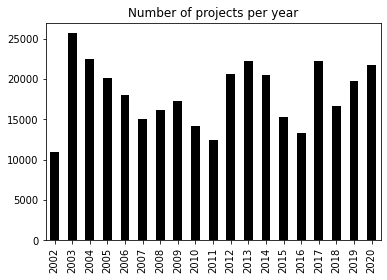

In [10]:
print(nsf['startYear'].value_counts().mean())
nsf['startYear'].value_counts().reindex(range(2002,2021)).plot(kind='bar',title='Number of projects per year',color='k')

### Award Amount

In [11]:
print('Mean award per project: ',nsf['AwardAmount'].mean())
print('Mean award per year: ',nsf.groupby('startYear')['AwardAmount'].sum().mean())

Mean award per project:  511156.59093243873
Mean award per year:  9270524254.0


Total budget per year:
startYear
2002     6267171113
2003    11093917405
2004     9481231140
2005     8683551522
2006     7893572566
2007     6997494867
2008     7946742778
2009    11901933429
2010     7909738516
2011     7003875429
2012    10291896687
2013    10046957616
2014    10454472757
2015     9508472081
2016     6927451040
2017    10943188972
2018    10112951448
2019    12516232046
2020    10159109414
Name: AwardAmount, dtype: int64


<AxesSubplot:title={'center':'Total awards (yearly)'}, xlabel='startYear'>

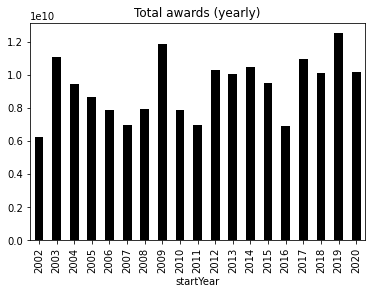

In [12]:
# total award per year
print('Total budget per year:')
print(nsf.groupby('startYear')['AwardAmount'].sum())
nsf.groupby('startYear')['AwardAmount'].sum().plot(kind='bar',title='Total awards (yearly)',color='k')

### Country Name

In [14]:
nsf['CountryName'].value_counts()

United States      344167
Bermuda               112
Canada                 62
United Kingdom         53
France                 40
Germany                34
Uruguay                31
Sweden                 18
Switzerland            10
Australia               8
Denmark                 6
New Zealand             4
Austria                 4
Russia                  3
Spain                   3
Italy                   3
Finland                 3
Netherlands             3
Paraguay                2
Japan                   2
Taiwan                  2
Puerto Rico             2
Israel                  1
Ukraine                 1
South Africa            1
Sri Lanka               1
Turkey                  1
Australasia             1
Colombia                1
Mexico                  1
Estonia                 1
Cameroon                1
Germany, Berlin         1
Venezuela               1
Belgium                 1
India                   1
Antarctica              1
Name: CountryName, dtype: int64

### State Name

Number of states and other territories:  57
California              43642
New York                26653
Massachusetts           23141
Texas                   18343
Pennsylvania            18014
Illinois                15175
Michigan                11631
North Carolina          10802
Florida                 10406
Virginia                 9743
Colorado                 9479
Maryland                 8989
Ohio                     8841
Georgia                  8738
New Jersey               8438
Indiana                  8275
Washington               8043
Arizona                  7846
Wisconsin                6050
District of Columbia     5938
Minnesota                5424
Oregon                   5117
Connecticut              4802
Missouri                 4449
Tennessee                4123
Rhode Island             3882
Iowa                     3621
Utah                     3546
South Carolina           3257
Louisiana                3102
Alabama                  3067
New Mexico               2

<AxesSubplot:title={'center':'Number of projects per state'}>

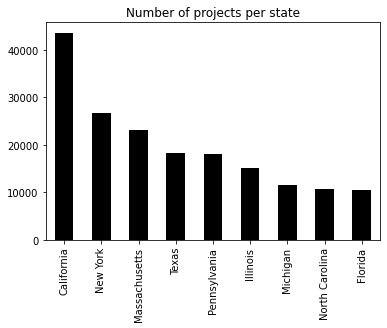

In [15]:
print('Number of states and other territories: ',len(nsf['StateName'].value_counts()))
print(nsf['StateName'].value_counts())
nsf['StateName'].value_counts().where(nsf['StateName'].value_counts()>10000).dropna().plot(kind='bar',color='k',title='Number of projects per state')

### Abstract narration

Average abstract narration length:  2376.2361365085535
startYear
2002    1927.578084
2003    2029.913671
2004    2072.247896
2005    2164.597111
2006    2129.291331
2007    2139.055548
2008    2157.117237
2009    2239.954960
2010    2235.964118
2011    2304.973738
2012    2305.164382
2013    2339.897648
2014    2532.826776
2015    2615.154658
2016    2624.964771
2017    2642.833311
2018    2880.780407
2019    2885.792299
2020    2920.378648
Name: AbstractNarration, dtype: float64


<AxesSubplot:title={'center':'Average abstract narration length (yearly)'}, xlabel='startYear'>

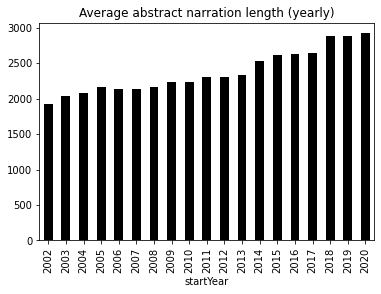

In [13]:
print('Average abstract narration length: ',nsf.groupby('startYear').AbstractNarration.apply(lambda x: x.str.len().mean()).reindex(range(2002,2021)).mean())
print(nsf.groupby('startYear').AbstractNarration.apply(lambda x: x.str.len().mean()))
nsf.groupby('startYear').AbstractNarration.apply(lambda x: x.str.len().mean()).plot(kind='bar',title='Average abstract narration length (yearly)',color='k')